In [1]:
# import packages
import pandas as pd
import plotly.graph_objects as go
import os, dotenv, sys, glob

In [12]:
# get the latest generated file location 
latest_file = max(glob.glob(os.path.join('../personal_envs/household-cashflow-analyzer/private/', "*.csv")), key = lambda x: os.path.basename(x))

In [5]:
# read the file
df = pd.read_csv(latest_file)
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['General_Type'] != 'Omit']

In [9]:
# define the function for preparing for the data of sankey chart
def sankey_data(raw_data, start_date, end_date):

    # only use data in the required time range
    used_df = raw_data[(raw_data['Date'] >= start_date) & (raw_data['Date'] <= end_date)]

    # income
    income_df = used_df[used_df['General_Type'] == 'Income'].groupby('Type').agg({'Amount': 'sum'})
    income_dict = dict(zip(income_df.index, income_df['Amount']))
    income_dict =  {key[8:] :income_dict[key]  for key in income_dict.keys()}

    # expense
    expense_df = used_df[used_df['General_Type'] != 'Income'].groupby('General_Type').agg({'Amount': 'sum'})
    expense_df['Amount'] = -expense_df['Amount']

    fixed_cost_df = expense_df[expense_df.index.isin(['Utility', 'Auto', 'Tax', 'Healthcare'])]
    fixed_cost_dict = dict(zip(fixed_cost_df.index, fixed_cost_df['Amount']))
    
    variable_cost_df = expense_df[expense_df.index.isin(['Entertainment', 'Grocery', 'Logistic', 'Online', 'Rent', 'Restaurant', 'Study'])]
    variable_cost_dict = dict(zip(variable_cost_df.index, variable_cost_df['Amount']))

    expense_dict = {"Fixed Cost": fixed_cost_dict, "Variable Cost": variable_cost_dict}

    # add profit/loss
    if income_df['Amount'].sum() >  expense_df['Amount'].sum():
        expense_dict['Profit'] = income_df['Amount'].sum() - expense_df['Amount'].sum()
    else:
        income_dict['Loss'] = expense_df['Amount'].sum() - income_df['Amount'].sum()

    # return the finding
    return income_dict, expense_dict

In [30]:
# define the function for preparing for plotting sankey chart
def plot_sankey(income_sources, expense_categories, title = "Household Cash Flow Sankey Chart"):

    # distinguish between categories having sub categories or end 
    clusters_with_children = {k: v for k, v in expense_categories.items() if isinstance(v, dict)}
    clusters_leaf = {k: v for k, v in expense_categories.items() if not isinstance(v, dict)}
    big_clusters = list(expense_categories.keys()) 
    
    # calculate the category total
    big_cluster_totals = {}
    for c, v in expense_categories.items():
        if isinstance(v, dict):
            big_cluster_totals[c] = sum(v.values())
        else:
            big_cluster_totals[c] = float(v)

    # get the nodes
    income_nodes = list(income_sources.keys())
    mid_nodes = ["Income"] + big_clusters

    # subcategories
    small_nodes = []
    for cluster, subdict in clusters_with_children.items():
        sorted_items = sorted(subdict.items(), key=lambda x: x[1], reverse=True)
        small_nodes += [name for name, _ in sorted_items]

    # get all lables
    labels = income_nodes + mid_nodes + small_nodes
    idx = {name: i for i, name in enumerate(labels)}

    # create the links
    sources, targets, values = [], [], []

    # income
    for name, val in income_sources.items():
        sources.append(idx[name])
        targets.append(idx["Income"])
        values.append(val)

    # income to category
    for cluster in big_clusters:
        sources.append(idx["Income"])
        targets.append(idx[cluster])
        values.append(big_cluster_totals[cluster])

    # category to subcategory
    for cluster, subdict in clusters_with_children.items():
        sorted_items = sorted(subdict.items(), key=lambda x: x[1], reverse=True)
        for subcat, val in sorted_items:
            sources.append(idx[cluster])
            targets.append(idx[subcat])
            values.append(val)

    # ploting
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,
            thickness=20,
            label=labels,
            line=dict(color="black", width=0.3),
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color="rgba(140,140,140,0.4)",
        ),
    )])

    fig.update_layout(
        title_text = title,
        font = dict(size = 13),
        height = 550,
        width = 1100,
    )
    fig.show()

In [31]:
# define the function of combining the above two functions together
def get_final_snakey(raw_data, start_date, end_date):
    income_sources, expense_sources = sankey_data(raw_data, start_date, end_date)
    plot_sankey(income_sources, expense_sources, "Household Cash Flow Sankey Chart: " + start_date + '~' + end_date)

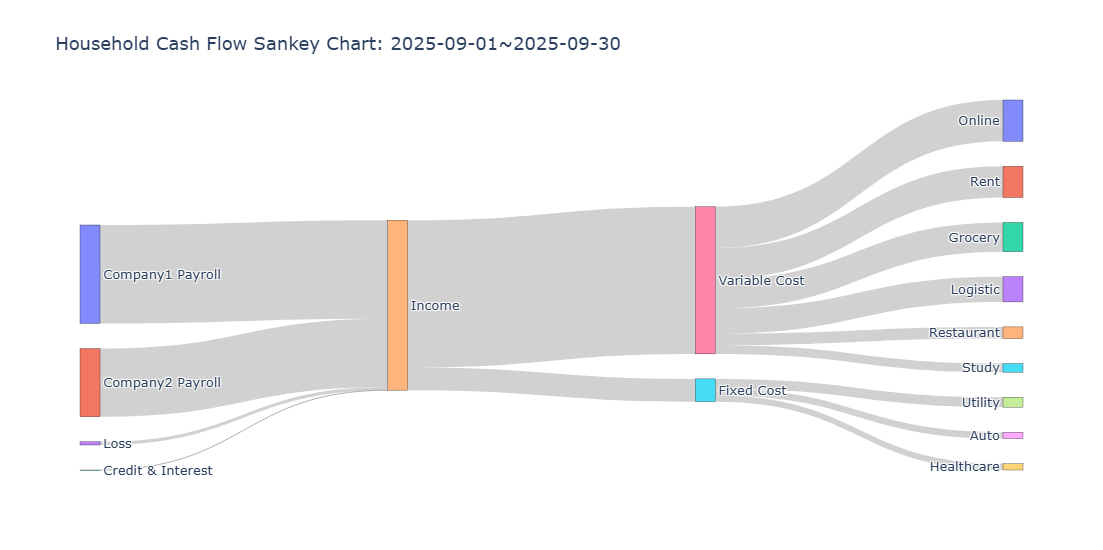

In [32]:
# get the result
get_final_snakey(df, '2025-09-01', '2025-09-30')